In [1]:
!pip install tensorflow==2.8.0

     |████████████████████████████████| 462 kB 5.3 MB/s 


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential
import json
import requests

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

currency='BTC-USD'

In [5]:
csv_path = "https://raw.githubusercontent.com/BearTS/TeamLosPolosHermanos-Technica22/main/"+currency+"%20(1%20year).csv?token=GHSAT0AAAAAABOYTPGDKAFSBYH7LBDA562MYUJHHPA"

In [6]:
df = pd.read_csv(csv_path)

In [7]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-05-20,36753.667969,42462.984375,35050.617188,40782.738281,40782.738281,88281943359
1,2021-05-21,40596.949219,42172.171875,33616.453125,37304.691406,37304.691406,82051616861
2,2021-05-22,37371.031250,38831.054688,35383.683594,37536.632813,37536.632813,57377273240
3,2021-05-23,37531.449219,38289.218750,31227.339844,34770.582031,34770.582031,78469274361
4,2021-05-24,34700.363281,39835.140625,34551.082031,38705.980469,38705.980469,67359584098


In [8]:
df.shape

(366, 7)

Text(0, 0.5, 'Closing Price in (USD)')

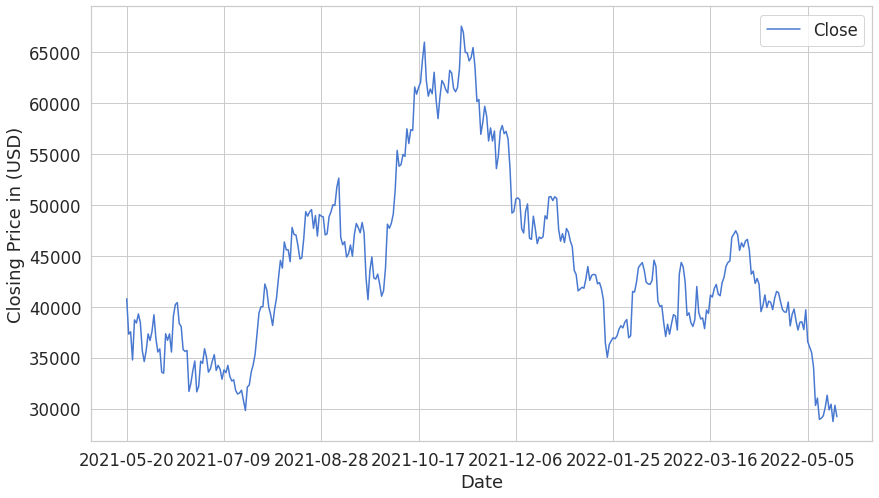

In [9]:
ax = df.plot(x='Date', y='Close');
ax.set_xlabel("Date")
ax.set_ylabel("Closing Price in (USD)")

# Normalization

In [10]:
scaler = MinMaxScaler()

close_price = df.Close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [11]:
scaled_close.shape

(366, 1)

In [12]:
np.isnan(scaled_close).any()

False

In [13]:
scaled_close = scaled_close.reshape(-1, 1)

# Preprocessing

In [14]:
SEQ_LEN = 20

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.8)

In [15]:
X_train.shape

(276, 19, 1)

In [16]:
X_test.shape

(70, 19, 1)

# Model

In [17]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

# Training

In [18]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [19]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
4/4 [==============================] - 22s 1s/step - loss: 0.1579 - val_loss: 0.0178
Epoch 2/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0408 - val_loss: 0.0099
Epoch 3/100
4/4 [==============================] - 0s 54ms/step - loss: 0.0235 - val_loss: 0.0397
Epoch 4/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0294 - val_loss: 0.0187
Epoch 5/100
4/4 [==============================] - 0s 62ms/step - loss: 0.0154 - val_loss: 0.0058
Epoch 6/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0200 - val_loss: 0.0045
Epoch 7/100
4/4 [==============================] - 0s 65ms/step - loss: 0.0189 - val_loss: 0.0053
Epoch 8/100
4/4 [==============================] - 0s 55ms/step - loss: 0.0142 - val_loss: 0.0089
Epoch 9/100
4/4 [==============================] - 0s 53ms/step - loss: 0.0135 - val_loss: 0.0119
Epoch 10/100
4/4 [==============================] - 0s 52ms/step - loss: 0.0133 - val_loss: 0.0098
Epoch 11/100
4/4 [==

In [20]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 13ms/step - loss: 0.0025


0.0025158978532999754

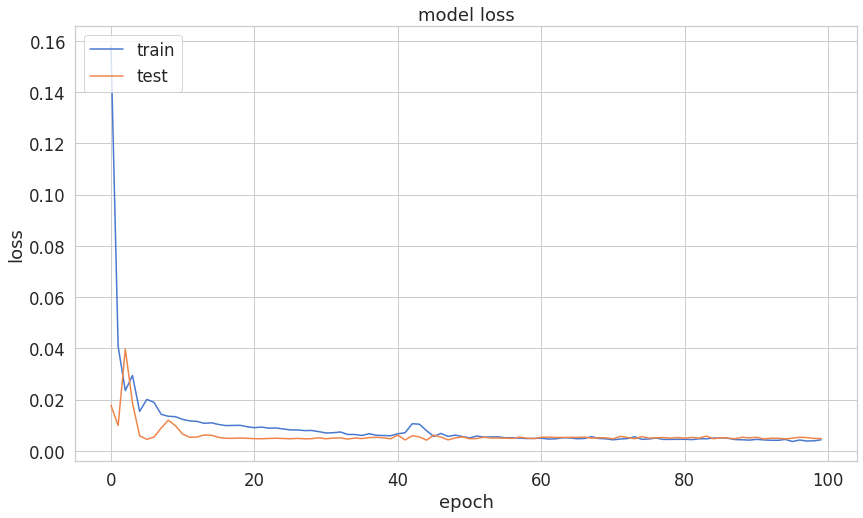

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction

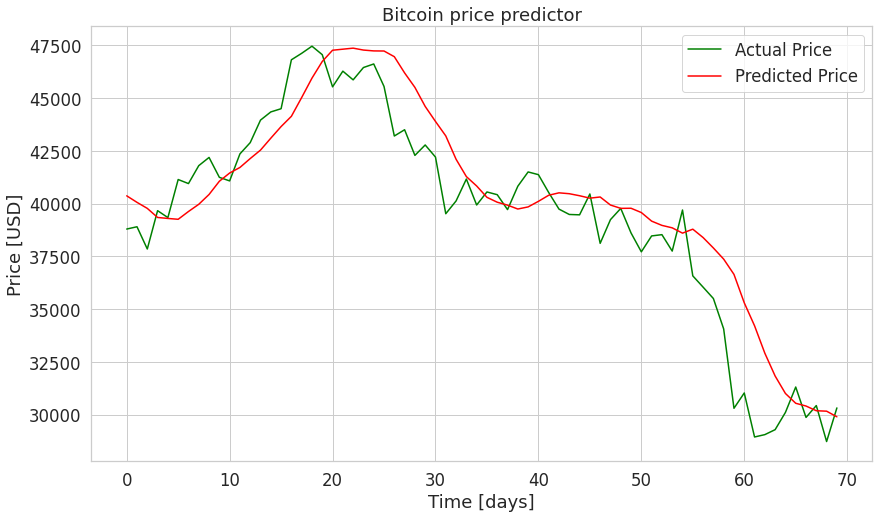

In [22]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price predictor')
plt.xlabel('Time [days]')
plt.ylabel('Price [USD]')
plt.legend(loc='best')
 
plt.show();

In [23]:
model.save("LSTM_crypto.h5")